In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import matplotlib.pyplot as plt
from hydra import initialize, compose
from pathlib import Path
from collections import defaultdict
import matplotlib.colors

In [2]:
with initialize(version_base=None, config_path="../configs/filepaths", ):
    filepaths = compose(config_name="filepaths")

In [3]:
Rs = [0, 1, 2, 3, 4]
dts = [98, 15, 6, 3, 2]
mechinferred_template_sizes = defaultdict(list)
rcr_template_sizes = defaultdict(list)
bad_rules = {'rcr': set(), 'mechinferred': set()}
mechinferred_rules = []
rcr_rules = []

for dt in dts:
    df = pd.read_csv(
        Path(filepaths.processed_data) / f"mechinferred_dt_{dt}_rules.csv",
    )
    mechinferred_rules.append(df)
    for _, row in df.iterrows():
        sma = row["smarts"]
        rxn = AllChem.ReactionFromSmarts(sma)
        mechinferred_template_sizes[dt].append(
            sum(rct.GetNumAtoms() for rct in rxn.GetReactants())
        )

for R in Rs:
    if R == 0:
        df = pd.read_csv(
            Path(filepaths.rules) / "rc_plus_0_rules.csv",
        )
    else:
        df = pd.read_csv(
            Path(filepaths.processed_data) / f"rc_plus_{R}_rules.csv",
        )
    rcr_rules.append(df)
    for _, row in df.iterrows():
        sma = row["smarts"]
        rxn = AllChem.ReactionFromSmarts(sma)
        rcr_template_sizes[R].append(
            sum(rct.GetNumAtoms() for rct in rxn.GetReactants())
        )


In [4]:
for df, cts in zip(mechinferred_rules, mechinferred_template_sizes.values()):
    df["n_atoms"] = cts
for df, cts in zip(rcr_rules, rcr_template_sizes.values()):
    df["n_atoms"] = cts

In [5]:
mechinferred_rules[4].sort_values(by="n_atoms", ascending=False)

,id,smarts,rc_plus_0_id,n_atoms
2955,2955,[*:1](~[*:2]~[*:3]~[*:4](~[O&D2&v2&H0&0*&R:5]-...,517,158
4871,4871,[*:1](~[*:2]~[*:3]~[*:4](~[O&D2&v2&H0&0*&R:5]-...,517,158
2543,2543,[*:1](~[*:2]~[*:3]~[*:4](~[O&D2&v2&H0&0*&R:5]-...,517,143
4079,4079,[*:1](~[*:2]~[*:3]~[*:4](~[O&D2&v2&H0&0*&R:5]-...,517,143
7797,7797,[*:1](~[*:2]~[*:3]~[*:4](~[O&D2&v2&H0&0*&R:5]-...,517,134
...,...,...,...,...
106,106,[N&D4&v4&H0&+&!R:1]-[C&D1&v4&H3&0*&!R&z1:2].[S...,469,3
487,487,[C&D1&v4&H3&0*&!R&z1:1]-[N&D4&v4&H0&+&R:2].[S&...,469,3
1989,1989,([C&D4&v4&H0&0*&R&z1:1]-[O&D2&v2&H0&0*&R:2].[O...,201,3
5485,5485,[C&D2&v4&H2&0*&!R&z1:1]-[N&D2&v3&H1&0*&!R:2].[...,316,3


In [6]:
rcr_rules[4].sort_values(by="n_atoms", ascending=False)

,id,smarts,rc_plus_0_id,n_atoms
6070,6070,[N&D1&v3&H2&0*&!R:1]-[C&D3&v4&H0&0*&!R&z2:2](=...,337,51
6234,6234,[N&D1&v3&H2&0*&!R:1]-[C&D3&v4&H0&0*&!R&z2:2](=...,463,51
2757,2757,[C&D1&v4&H2&0*&!R&z0:1]=[C&D2&v4&H1&0*&!R&z0:2...,684,49
5185,5185,[N&D1&v3&H2&0*&!R:1]-[C&D3&v4&H0&0*&!R&z2:2](=...,337,48
1461,1461,[N&D1&v3&H2&0*&!R:1]-[C&D3&v4&H0&0*&!R&z2:2](=...,463,48
...,...,...,...,...
8507,8507,[O&D1&v2&H0&0*&!R:1]=[C&D2&v4&H0&0*&!R&z2:2]=[...,495,4
8692,8692,[C&D1&v4&H1&0*&!R&z0:1]#[C&D1&v4&H1&0*&!R&z0:2...,553,3
7235,7235,[C&D1&v4&H1&0*&!R&z1:1]#[N&D1&v3&H0&0*&!R:2].[...,549,3
2800,2800,[C&D1&v4&H3&0*&!R&z0:1]-[C&D2&v4&H1&0*&!R&z1:2...,185,3


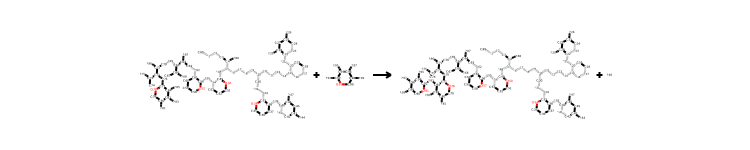

In [7]:
AllChem.ReactionFromSmarts(mechinferred_rules[2].loc[4439, "smarts"])

In [8]:
colors = {
    'rc_plus_0_rules': matplotlib.colors.to_rgba("black", alpha=0.3),
    'rc_plus_1_rules':matplotlib.colors.to_rgba("black", alpha=0.45),
    'rc_plus_2_rules': matplotlib.colors.to_rgba("black", alpha=0.6),
    'rc_plus_3_rules': matplotlib.colors.to_rgba("black", alpha=0.85),
    'rc_plus_4_rules': matplotlib.colors.to_rgba("black", alpha=1.0),
    'mechinferred_dt_98_rules': matplotlib.colors.to_rgba("purple", alpha=0.3),
    'mechinferred_dt_15_rules': matplotlib.colors.to_rgba("purple", alpha=0.45),
    'mechinferred_dt_6_rules': matplotlib.colors.to_rgba("purple", alpha=0.6),
    'mechinferred_dt_3_rules': matplotlib.colors.to_rgba("purple", alpha=0.85),
    'mechinferred_dt_2_rules': matplotlib.colors.to_rgba("purple", alpha=1.0)
}

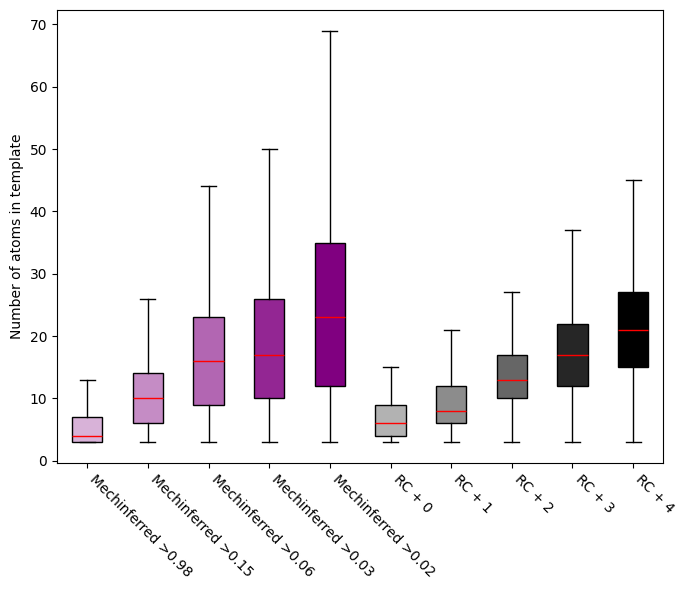

In [9]:
fig, ax = plt.subplots(figsize=(7, 6))
data = []
width = 0.5

for dt, cts in mechinferred_template_sizes.items():
    data.append(cts)
for R, cts in rcr_template_sizes.items():
    data.append(cts)

positions = list(range(len(mechinferred_template_sizes) + len(rcr_template_sizes)))

bw_plot = ax.boxplot(data, positions=positions, widths=width, patch_artist=True, showfliers=False, medianprops={'color': 'red'})

for path, dt in zip(bw_plot['boxes'], mechinferred_template_sizes.keys()):
    color_key = f"mechinferred_dt_{dt}_rules"
    color = colors[color_key]
    path.set_facecolor(color)

for path, R in zip(bw_plot['boxes'][len(mechinferred_template_sizes):], rcr_template_sizes.keys()):
    color_key = f"rc_plus_{R}_rules"
    color = colors[color_key]
    path.set_facecolor(color)

ax.set_xticks(positions)
xticklabels = [f"Mechinferred >{dt/100:.2f}" for dt in dts] + [f"RC + {R}" for R in Rs]
ax.set_xticklabels(xticklabels, rotation=-45, ha='left')
ax.set_ylabel("Number of atoms in template")
plt.tight_layout()
fig.savefig(Path(filepaths.figures) / "template_size_boxplot.svg", format='svg')
plt.show()